# 과제 - 3주차

* 데이터 확인용 기초코드

In [1]:
from pyspark.sql import SparkSession

# SparkSession
spark = (
    SparkSession.builder
        .appName("rdd-dataframe")
        .master("local")
        .getOrCreate()
)

# SparkContext를 SparkSession에서 빼두기
sc = spark.sparkContext

# 하단 메시지는 Jupyter 공식이미지에서 나오는 메시지로, 무시하기

24/08/28 14:01:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
#json파일로 저장해 둔 스키마 불러오기

import json
from pyspark.sql.types import StructType

# Define the path to the JSON file
input_file_path = 'github_schema.json'

# Open and load the JSON file
with open(input_file_path, 'r') as json_file:
    github_schema = json.load(json_file)

In [ ]:
# 스키마 확인하기

def find_all_names(data, current_path=[]):
    paths = []
    if isinstance(data, dict):
        if 'name' in data:
            # Collect the path to the current 'name'
            paths.append('.'.join(current_path + [data['name']]))
        # Recursively search within this dictionary
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                paths.extend(find_all_names(value, current_path + [data.get('name', key)]))
    elif isinstance(data, list):
        for item in data:
            paths.extend(find_all_names(item, current_path))
    return paths

for each_line in find_all_names(github_schema):
    print(each_line.replace('fields.',''))

In [49]:
# 저장한 스키마로 파일 읽기 (빠른 확인을 위해 1개의 gh archive데이터만 사용)
from pyspark.sql.types import StructType

schema_to_read = StructType.fromJson(github_schema)
df = spark.read.schema(schema_to_read).json("../data/gh_archive/2024-07-01-14.json.gz")

In [ ]:
# 저장한 스키마로 파일 읽기 (전체파일)
from pyspark.sql.types import StructType

schema_to_read = StructType.fromJson(github_schema)
df = spark.read.schema(schema_to_read).json("../data/gh_archive/2024-07-01-14.json.gz")

In [61]:
# 데이터 확인

import pyspark.sql.functions as F

columns = ['actor.login','type']
select_exprs = [F.col(col_path).alias(col_path) for col_path in columns]

df2 = df.select(*select_exprs)
df2.show()

+--------------------+--------------------+
|         actor.login|                type|
+--------------------+--------------------+
|       CosmomediaCEO|           PushEvent|
|         ayomide3211|         CreateEvent|
|         julianwagle|           PushEvent|
|               RTann|PullRequestReview...|
|       HttpAnimation|           PushEvent|
|           thunderv3|           PushEvent|
| github-actions[bot]|           PushEvent|
|             aspiers|PullRequestReview...|
| github-actions[bot]|           PushEvent|
|     acciojob-5[bot]|         CreateEvent|
|            dfitzmau|   IssueCommentEvent|
|      steven-bellock|   IssueCommentEvent|
|           rssfeeder|           PushEvent|
|     dependabot[bot]|         CreateEvent|
|    Naveen-Palanivel|         CreateEvent|
|          lukerQuant|   IssueCommentEvent|
|      ZaidQourah2004|         CreateEvent|
|youngZwiebelandth...|           PushEvent|
|    abhishekpaturkar|         CreateEvent|
|       TANGHANHUTNAM|          

## 1. spark-submit.sh 스크립트 참고해서 option 바꾸어보기

```
<path-to-spark-submit>/spark-submit \
    --class <project.class.path> \
    --name HelloWorld \    # job name지정
    --master spark://spark-master:7077 \                     # master(현재 실습기준으로는 local)
    --driver-cores 2 \                                       # optimization옵션에 해당
    --driver-memory 2g \                                     # optimization옵션에 해당
    --num-executors 4 \                                      # optimization옵션에 해당
    --executor-cores 2 \                                     # optimization옵션에 해당 (병렬처리를 얼마나 많이 할지)
    --executor-memory 2g \                                   # optimization옵션에 해당
    --conf spark.driver.memoryOverhead=1g                    # 
    --conf spark.executor.memoryOverhead=1g                  # 
    --conf spark.dynamicAllocation.enabled=true \            #
    --conf spark.dynamicAllocation.executorIdleTimeout=2m \  # 
    --conf spark.dynamicAllocation.minExecutors=1 \          #
    --conf spark.dynamicAllocation.maxExecutors=9 \          #
    --conf spark.dynamicAllocation.initialExecutors=1 \      #
    --conf spark.memory.offHeap.enabled=true \               #
    --conf spark.memory.offHeap.size=2G \                    #
    --conf spark.shuffle.service.enabled=true \              #
    --conf spark.driver.maxResultSize=0 \                    #
    --conf spark.logConf=true \                              #
    --jars /opt/bitnami/spark/resources/elasticsearch-spark-30_2.12-8.4.3.jar
```


* 미사용
  * --class <project.class.path>   # 실행될 기본 클래스 지정
  * --deploy-mode : client/cluster # yarn 등 미사용중       

## 2. 원하는 최종 스키마를 만들기 위한 정제 코드 filter.py 작성하기

In [ ]:
# main.py
def init_df(df):
    df = df.select('created_at', 'id', 'payload', 'type', df.actor.login.alias('login'), df.actor.url.alias('url'), 'repo')
    df = df.select('login', 'url', 'created_at', 'id', df.payload.repository_id.alias('repository_id'), \
                   df.payload.size.alias('size'), df.payload.distinct_size.alias('distinct_size'), \
                   df.payload.comment.alias('comment'), 'type', 'repo')
    df = df.select('login', 'url', 'created_at', 'id', 'repository_id', 'size', 'distinct_size', 'comment', 'type', \
                   F.col('repo.name').alias('name'), df.repo.url.alias('repo_url'))
    
    n_cols = ['user_name', 'url', 'created_at', 'id', 'repository_id', 'size', 'distinct_size', 'comment', \
            'type', 'name', 'repo_url']
    df = df.toDF(*n_cols)

    df = df.filter(F.col("login") != "github-actions[bot]")
    df = df.withColumn('created_at', F.trim(F.regexp_replace(df.created_at, "[TZ]", " ")))
    df = df.withColumn('created_at', F.to_timestamp(df.created_at, 'yyyy-MM-dd HH:mm:ss'))

    # For pytorch filter
    ## pytorch/pytorch(아이디/레포이름)으로 필터를 걸 예정
    df = df.withColumn('userid_and_repo_name', 'repo_name')

    udf_check_repo_name = F.udf(lambda name: name.split("/")[-1], StringType())
    df = df.withColumn('repo_name', udf_check_repo_name(F.col('name')))
    df = df.drop('name')

    return df

In [ ]:
# filter.py
class PytorchTopIssuerFilter(BaseFilter):
    def filter(self, df):
        # Filter : repo_name = pytorch
        base_df = df.filter(F.col('userid_and_repo_name') == 'pytorch/pytorch')

        # groupby : 
        result_df = base_df.groupBy('user_name').pivot('type').count()
        result_df = result_df.cache()
        result_df.where((~F.col('user_name').contains('[bot]'))) \
                    .orderBy(F.desc('IssuesEvent')) \
                    .limit(10)
        return result_df

## 3. 작성한 정제 코드 spark-submit 해보기
* 제출할 내용: spark-submit.sh, filter.py (파일명은 바꾸셔도 무방합니다)

docker exec -it metacode_de-2024-spark-master-1 spark-submit --master spark://spark-master:7077 jobs/filter.py

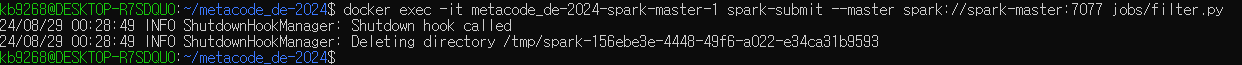

## 기타(과제X) : spark-submit 테스트 해보기

In [ ]:
* 구동시간을 출력하는 테스트용 파일로 옵션을 바꿔가며 spark-submit으로 테스트 해 볼 예정
* 사용데이터 : gharchive 7월분 파일(39.3GB)
* 편의용 커맨드 기록
  * docker exec -it metacode_de-2024-spark-master-1 spark-submit --master spark://spark-master:7077 jobs/test_for_spark_option.py

In [ ]:
# 테스트에 사용한 코드 (test_for_spark_option.py)
import time
import json
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
import pyspark.sql.functions as F

### 시작시간 기록
start_time = time.time()

### 테스트용 코드

# SparkSession
spark = (
    SparkSession.builder
        .appName("rdd-dataframe")
        .master("local")
        .getOrCreate()
)
# SparkContext
sc = spark.sparkContext

#json파일로 저장해 둔 스키마 불러오기
input_file_path = './jobs/github_schema.json'
with open(input_file_path, 'r') as json_file:
    github_schema = json.load(json_file)

# 저장한 스키마로 파일 읽기 (1달치)
schema_to_read = StructType.fromJson(github_schema)
df = spark.read.schema(schema_to_read).json("./data/gh_archive/*.json.gz")

# 데이터 확인 (actor.login컬럼의 전체데이터 distinct)
columns = ['actor.login']
select_exprs = [F.col(col_path).alias(col_path) for col_path in columns]

df.select(*select_exprs).distinct().show(10,False)

### 종료시간 기록 후 구동시간 출력
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.4f} seconds")

In [ ]:
# 주피터에서 테스트하는 코드
import subprocess
import time

list_option = [['spark.executor.memory=2G','spark.executor.memory=3G'],
               ['spark.executor.memory=2G','spark.executor.memory=4G'],
               ['driver.memory=2G','driver.memory=3G'],
               ['driver.memory=2G','driver.memory=4G'],
               ['driver.memory=2G','driver.memory=4G'],
               ['driver.memory=2G','driver.memory=4G'],
               ['--executor-cores 1','--executor-cores 2'],
               ['--executor-cores 1','--executor-cores 3'],
    
]

dict_result = []
for option in list_option:
    #print(option[1])
    ## spark-submit.sh 파일을 생성 또는 수정하는 Python 코드
    script_content = """#!/bin/bash

    JARS="/opt/bitnami/spark/resources/elasticsearch-spark-30_2.12-8.4.3.jar"

    JOBNAME="RefinePipeline"
    SCRIPT=$@
    echo ${SCRIPT}

    spark-submit \\
      --name ${JOBNAME} \\
      --master spark://spark-master:7077 \\
      --jars ${JARS} \\
      --conf spark.dynamicAllocation.enabled=true \\
      --conf spark.dynamicAllocation.executorIdleTimeout=2m \\
      --conf spark.dynamicAllocation.minExecutors=1 \\
      --conf spark.dynamicAllocation.maxExecutors=9 \\
      --conf spark.dynamicAllocation.initialExecutors=1 \\
      --conf spark.memory.offHeap.enabled=true \\
      --conf spark.memory.offHeap.size=2G \\
      --conf spark.shuffle.service.enabled=true \\
      --conf spark.executor.memory=2G \\
      --conf spark.driver.memory=2G \\
      --conf spark.driver.maxResultSize=0 \\
      --num-executors 2 \\
      --executor-cores 1 \\
      ${SCRIPT}
    """

    # 파일 작성
    with open("spark-submit.sh", "w") as file:
        file.write(script_content)

    ## spark-submit.sh를 실행해 시간을 측정해보는 코드

    # 실행할 파이썬 스크립트 경로
    script_path = "../jobs/test_for_spark_option.py"

    # spark-submit.sh 스크립트를 실행할 커맨드
    command = f"bash spark-submit.sh {script_path}"

    # 시간 측정 시작
    start_time = time.time()

    # 커맨드 실행
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

    # 시간 측정 종료
    end_time = time.time()

    # 실행 시간 계산
    execution_time = end_time - start_time
    

    # 결과 출력 및 기록
    dict_result[option[1]] = {'time':execution_time}
    print(f"{option[1]} : {execution_time}")

* spark-submit.sh 기본옵션 기준 > 오류남 > 퇴근하고 확인해보기

24/08/29 01:21:45 INFO TaskSchedulerImpl: Cancelling stage 1
24/08/29 01:21:45 INFO TaskSchedulerImpl: Killing all running tasks in stage 1: Stage cancelled: Job aborted due to stage failure: Task 369 in stage 1.0 failed 1 times, most recent failure: Lost task 369.0 in stage 1.0 (TID 803) (spark-master executor driver): java.io.EOFException: Unexpected end of input stream
        at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:165)
        at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
        at java.base/java.io.InputStream.read(InputStream.java:218)
        at org.apache.hadoop.util.LineReader.fillBuffer(LineReader.java:191)
        at org.apache.hadoop.util.LineReader.readDefaultLine(LineReader.java:227)
        at org.apache.hadoop.util.LineReader.readLine(LineReader.java:185)
        at org.apache.hadoop.mapreduce.lib.input.LineRecordReader.nextKeyValue(LineRecordReader.java:200)
        at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
        at org.apache.spark.sql.execution.datasources.HadoopFileLinesReader.hasNext(HadoopFileLinesReader.scala:67)
        at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithKeys_0$(Unknown Source)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
        at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
        at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
        at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
        at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
        at org.apache.spark.scheduler.Task.run(Task.scala:141)
        at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
        at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
        at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
        at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
        at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
        at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
24/08/29 01:21:45 INFO Executor: Executor is trying to kill task 370.0 in stage 1.0 (TID 804), reason: Stage cancelled: Job aborted due to stage failure: Task 369 in stage 1.0 failed 1 times, most recent failure: Lost task 369.0 in stage 1.0 (TID 803) (spark-master executor driver): java.io.EOFException: Unexpected end of input stream
        at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:165)
        at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
        at java.base/java.io.InputStream.read(InputStream.java:218)
        at org.apache.hadoop.util.LineReader.fillBuffer(LineReader.java:191)
        at org.apache.hadoop.util.LineReader.readDefaultLine(LineReader.java:227)
        at org.apache.hadoop.util.LineReader.readLine(LineReader.java:185)
        at org.apache.hadoop.mapreduce.lib.input.LineRecordReader.nextKeyValue(LineRecordReader.java:200)
        at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
        at org.apache.spark.sql.execution.datasources.HadoopFileLinesReader.hasNext(HadoopFileLinesReader.scala:67)
        at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithKeys_0$(Unknown Source)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
        at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
        at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
        at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
        at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
        at org.apache.spark.scheduler.Task.run(Task.scala:141)
        at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
        at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
        at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
        at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
        at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
        at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
24/08/29 01:21:45 INFO TaskSchedulerImpl: Stage 1 was cancelled
24/08/29 01:21:45 INFO DAGScheduler: ShuffleMapStage 1 (showString at NativeMethodAccessorImpl.java:0) failed in 1660.866 s due to Job aborted due to stage failure: Task 369 in stage 1.0 failed 1 times, most recent failure: Lost task 369.0 in stage 1.0 (TID 803) (spark-master executor driver): java.io.EOFException: Unexpected end of input stream
        at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:165)
        at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
        at java.base/java.io.InputStream.read(InputStream.java:218)
        at org.apache.hadoop.util.LineReader.fillBuffer(LineReader.java:191)
        at org.apache.hadoop.util.LineReader.readDefaultLine(LineReader.java:227)
        at org.apache.hadoop.util.LineReader.readLine(LineReader.java:185)
        at org.apache.hadoop.mapreduce.lib.input.LineRecordReader.nextKeyValue(LineRecordReader.java:200)
        at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
        at org.apache.spark.sql.execution.datasources.HadoopFileLinesReader.hasNext(HadoopFileLinesReader.scala:67)
        at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithKeys_0$(Unknown Source)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
        at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
        at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
        at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
        at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
        at org.apache.spark.scheduler.Task.run(Task.scala:141)
        at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
        at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
        at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
        at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
        at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
        at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
24/08/29 01:21:45 INFO Executor: Executor killed task 370.0 in stage 1.0 (TID 804), reason: Stage cancelled: Job aborted due to stage failure: Task 369 in stage 1.0 failed 1 times, most recent failure: Lost task 369.0 in stage 1.0 (TID 803) (spark-master executor driver): java.io.EOFException: Unexpected end of input stream
        at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:165)
        at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
        at java.base/java.io.InputStream.read(InputStream.java:218)
        at org.apache.hadoop.util.LineReader.fillBuffer(LineReader.java:191)
        at org.apache.hadoop.util.LineReader.readDefaultLine(LineReader.java:227)
        at org.apache.hadoop.util.LineReader.readLine(LineReader.java:185)
        at org.apache.hadoop.mapreduce.lib.input.LineRecordReader.nextKeyValue(LineRecordReader.java:200)
        at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
        at org.apache.spark.sql.execution.datasources.HadoopFileLinesReader.hasNext(HadoopFileLinesReader.scala:67)
        at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithKeys_0$(Unknown Source)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
        at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
        at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
        at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
        at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
        at org.apache.spark.scheduler.Task.run(Task.scala:141)
        at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
        at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
        at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
        at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
        at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
        at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
24/08/29 01:21:45 WARN TaskSetManager: Lost task 370.0 in stage 1.0 (TID 804) (spark-master executor driver): TaskKilled (Stage cancelled: Job aborted due to stage failure: Task 369 in stage 1.0 failed 1 times, most recent failure: Lost task 369.0 in stage 1.0 (TID 803) (spark-master executor driver): java.io.EOFException: Unexpected end of input stream
        at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:165)
        at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
        at java.base/java.io.InputStream.read(InputStream.java:218)
        at org.apache.hadoop.util.LineReader.fillBuffer(LineReader.java:191)
        at org.apache.hadoop.util.LineReader.readDefaultLine(LineReader.java:227)
        at org.apache.hadoop.util.LineReader.readLine(LineReader.java:185)
        at org.apache.hadoop.mapreduce.lib.input.LineRecordReader.nextKeyValue(LineRecordReader.java:200)
        at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
        at org.apache.spark.sql.execution.datasources.HadoopFileLinesReader.hasNext(HadoopFileLinesReader.scala:67)
        at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithKeys_0$(Unknown Source)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
        at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
        at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
        at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
        at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
        at org.apache.spark.scheduler.Task.run(Task.scala:141)
        at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
        at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
        at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
        at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
        at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
        at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:)
24/08/29 01:21:45 INFO TaskSchedulerImpl: Removed TaskSet 1.0, whose tasks have all completed, from pool
Traceback (most recent call last):
  File "/opt/bitnami/spark/jobs/test_for_spark_option.py", line 35, in <module>
    df.select(*select_exprs).distinct().show(10,False)
  File "/opt/bitnami/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py", line 947, in show
  File "/opt/bitnami/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py", line 978, in _show_string
  File "/opt/bitnami/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1322, in __call__
  File "/opt/bitnami/spark/python/lib/pyspark.zip/pyspark/errors/exceptions/captured.py", line 179, in deco
  File "/opt/bitnami/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/protocol.py", line 326, in get_return_value
py4j.protocol.Py4JJavaError: An error occurred while calling o42.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 369 in stage 1.0 failed 1 times, most recent failure: Lost task 369.0 in stage 1.0 (TID 803) (spark-master executor driver): java.io.EOFException: Unexpected end of input stream
        at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:165)
        at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
        at java.base/java.io.InputStream.read(InputStream.java:218)
        at org.apache.hadoop.util.LineReader.fillBuffer(LineReader.java:191)
        at org.apache.hadoop.util.LineReader.readDefaultLine(LineReader.java:227)
        at org.apache.hadoop.util.LineReader.readLine(LineReader.java:185)
        at org.apache.hadoop.mapreduce.lib.input.LineRecordReader.nextKeyValue(LineRecordReader.java:200)
        at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
        at org.apache.spark.sql.execution.datasources.HadoopFileLinesReader.hasNext(HadoopFileLinesReader.scala:67)
        at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithKeys_0$(Unknown Source)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
        at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
        at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
        at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
        at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
        at org.apache.spark.scheduler.Task.run(Task.scala:141)
        at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
        at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
        at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
        at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
        at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
        at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
        at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
        at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
        at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
        at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
        at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
        at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
        at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
        at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
        at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
        at scala.Option.foreach(Option.scala:407)
        at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
        at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
        at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
        at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
        at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.io.EOFException: Unexpected end of input stream
        at org.apache.hadoop.io.compress.DecompressorStream.decompress(DecompressorStream.java:165)
        at org.apache.hadoop.io.compress.DecompressorStream.read(DecompressorStream.java:105)
        at java.base/java.io.InputStream.read(InputStream.java:218)
        at org.apache.hadoop.util.LineReader.fillBuffer(LineReader.java:191)
        at org.apache.hadoop.util.LineReader.readDefaultLine(LineReader.java:227)
        at org.apache.hadoop.util.LineReader.readLine(LineReader.java:185)
        at org.apache.hadoop.mapreduce.lib.input.LineRecordReader.nextKeyValue(LineRecordReader.java:200)
        at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
        at org.apache.spark.sql.execution.datasources.HadoopFileLinesReader.hasNext(HadoopFileLinesReader.scala:67)
        at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithKeys_0$(Unknown Source)
        at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
        at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
        at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
        at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
        at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
        at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
        at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
        at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
        at org.apache.spark.scheduler.Task.run(Task.scala:141)
        at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
        at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
        at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
        at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
        at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
        at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
        at java.base/java.lang.Thread.run(Thread.java:840)

24/08/29 01:21:45 INFO SparkContext: Invoking stop() from shutdown hook
24/08/29 01:21:45 INFO SparkContext: SparkContext is stopping with exitCode 0.
24/08/29 01:21:45 INFO SparkUI: Stopped Spark web UI at http://spark-master:4040
24/08/29 01:21:45 INFO MapOutputTrackerMasterEndpoint: MapOutputTrackerMasterEndpoint stopped!
24/08/29 01:21:45 INFO MemoryStore: MemoryStore cleared
24/08/29 01:21:45 INFO BlockManager: BlockManager stopped
24/08/29 01:21:45 INFO BlockManagerMaster: BlockManagerMaster stopped
24/08/29 01:21:45 INFO OutputCommitCoordinator$OutputCommitCoordinatorEndpoint: OutputCommitCoordinator stopped!
24/08/29 01:21:45 INFO SparkContext: Successfully stopped SparkContext
24/08/29 01:21:45 INFO ShutdownHookManager: Shutdown hook called
24/08/29 01:21:45 INFO ShutdownHookManager: Deleting directory /tmp/spark-5042288d-526e-4150-add6-8602d16687f7/pyspark-d4272a2c-4c0d-425d-a0a1-375c07ab395d
24/08/29 01:21:45 INFO ShutdownHookManager: Deleting directory /tmp/spark-5042288d-526e-4150-add6-8602d16687f7
24/08/29 01:21:45 INFO ShutdownHookManager: Deleting directory /tmp/spark-9676e47a-6a66-4361-820b-c9a9204143fc